In [43]:
import pandas as pd
import urllib.parse

# Read the TSV file
paths_finished_df = pd.read_csv('data/wikispeedia_paths-and-graph/paths_finished.tsv', 
                                sep='\t', 
                                comment='#', 
                                names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])

paths_finished_df['target'] = paths_finished_df['path'].apply(lambda x: urllib.parse.unquote(x.split(';')[-1]).replace('_', ' '))
paths_finished_df['is_finished'] = True

paths_unfinished_df = pd.read_csv('data/wikispeedia_paths-and-graph/paths_unfinished.tsv', 
                                sep='\t', 
                                comment='#', 
                                names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])
paths_unfinished_df['is_finished'] = False

paths_df = pd.concat([paths_finished_df, paths_unfinished_df])



In [44]:
import urllib.parse

def find_backtracks(path):
    backtracks = []
    words = path.split(';')
    stack = []

    for word in words:
        if word == "<":
            if stack:
                backtracks.append(stack.pop())
        else:
            url_decoded = urllib.parse.unquote(word).replace('_', ' ')
            stack.append(url_decoded)

    return backtracks

paths_df['backtracks'] = paths_df['path'].apply(find_backtracks)

backtracks = pd.Series(paths_df['backtracks'].explode().dropna().tolist())
print(backtracks.value_counts())

United States       543
United Kingdom      352
England             333
Europe              252
Animal              229
                   ... 
Mauritania            1
Common Cuckoo         1
Citizen Kane          1
African Wild Dog      1
Riesling              1
Name: count, Length: 2911, dtype: int64


In [45]:
#plot backtracks
pd.Series(backtracks).value_counts()
# Print the full value counts for backtracks
print(backtracks.value_counts().to_string())


United States                                                     543
United Kingdom                                                    352
England                                                           333
Europe                                                            252
Animal                                                            229
Mammal                                                            195
World War II                                                      187
North America                                                     175
Herbivore                                                         168
Great Britain                                                     165
France                                                            165
Africa                                                            160
Film                                                              154
Internet                                                          143
Plant               

In [46]:

top_backtracks = backtracks.value_counts()
top_backtracks[top_backtracks >= 10]

United States        543
United Kingdom       352
England              333
Europe               252
Animal               229
                    ... 
Yeast                 10
Soil science          10
Biofuel               10
Drought               10
Liberal democracy     10
Name: count, Length: 849, dtype: int64

In [47]:
def path_to_list(path):
    return [urllib.parse.unquote(word).replace('_', ' ') for word in path.replace('<;', '').split(';')]

paths_df["traversed"] = paths_df["path"].apply(path_to_list)

paths_df.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,target,is_finished,type,backtracks,traversed
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,African slave trade,True,NaN,[],"[14th century, 15th century, 16th century, Pac..."
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,African slave trade,True,NaN,[],"[14th century, Europe, Africa, Atlantic slave ..."
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,African slave trade,True,NaN,[],"[14th century, Niger, Nigeria, British Empire,..."
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,Greece,True,NaN,[],"[14th century, Renaissance, Ancient Greece, Gr..."
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,John F. Kennedy,True,NaN,[],"[14th century, Italy, Roman Catholic Church, H..."


In [48]:
traversed = pd.Series(paths_df['traversed'].explode().dropna().tolist())

traversed.value_counts()

United States                 12449
Europe                         5611
United Kingdom                 5328
England                        4558
Earth                          4216
                              ...  
Steve Davis                       1
Tacitean studies                  1
Typhoon Ewiniar (2006)            1
Earwax                            1
Architecture of Windows NT        1
Name: count, Length: 4183, dtype: int64

                                                    backtracks  traversed  \
Wikipedia Text of the GNU Free Documentation Li...        61.0        122   
Salsa music                                               48.0        156   
DVD                                                       86.0        285   
Optical fiber                                             43.0        150   
Herbivore                                                168.0        594   
Eukaryote                                                 53.0        188   
Hellenistic Greece                                        29.0        103   
Landform                                                  27.0        105   
Gardening                                                 48.0        189   
Actor                                                     97.0        406   
Drawing                                                   28.0        120   
Carolus Linnaeus                                          35.0        152   

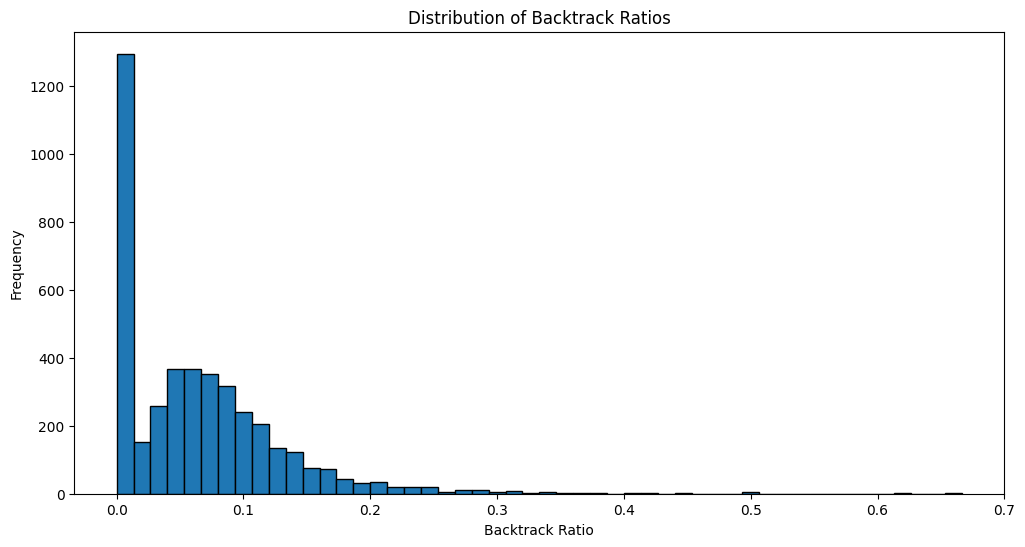

In [49]:
# Create a DataFrame with counts of backtracks and traversed
word_counts = pd.DataFrame({
    'backtracks': backtracks.value_counts(),
    'traversed': traversed.value_counts()
})

# Calculate the ratio of backtracks to traversed
word_counts['backtrack_ratio'] = word_counts['backtracks'] / word_counts['traversed']

# Fill NaN values with 0 (for words that were traversed but never backtracked)
word_counts['backtrack_ratio'] = word_counts['backtrack_ratio'].fillna(0)

# Sort by the ratio in descending order
word_counts_sorted = word_counts.sort_values('backtrack_ratio', ascending=False)

# Display the top 20 words with highest backtrack ratios for words with at least 100 occurrences
print(word_counts_sorted[word_counts_sorted['traversed'] >= 100].head(20))

# Optional: Plot the distribution of backtrack ratios
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(word_counts['backtrack_ratio'], bins=50, edgecolor='black')
plt.title('Distribution of Backtrack Ratios')
plt.xlabel('Backtrack Ratio')
plt.ylabel('Frequency')
plt.show()



In [50]:
# Calculate percentage of backtracks in finished vs unfinished paths
has_backtracks = paths_df['backtracks'].apply(len) > 0

# Get counts
finished_with_backtracks = (has_backtracks & paths_df['is_finished']).sum()
finished_total = paths_df['is_finished'].sum()

unfinished_with_backtracks = (has_backtracks & (~paths_df['is_finished'])).sum()
unfinished_total = (~paths_df['is_finished']).sum()

# Calculate percentages
finished_backtrack_pct = (finished_with_backtracks / finished_total) * 100
unfinished_backtrack_pct = (unfinished_with_backtracks / unfinished_total) * 100

print(f"Paths with backtracks:")
print(f"Finished paths: {finished_backtrack_pct:.1f}% ({finished_with_backtracks}/{finished_total})")
print(f"Unfinished paths: {unfinished_backtrack_pct:.1f}% ({unfinished_with_backtracks}/{unfinished_total})")


Paths with backtracks:
Finished paths: 17.5% (8995/51318)
Unfinished paths: 20.9% (5201/24875)


In [51]:
# Calculate average number of backtracks for finished vs unfinished paths
avg_backtracks_finished = paths_df[paths_df['is_finished']]['backtracks'].apply(len).mean()
avg_backtracks_unfinished = paths_df[~paths_df['is_finished']]['backtracks'].apply(len).mean()

print("\nAverage number of backtracks per game:")
print(f"Finished paths: {avg_backtracks_finished:.2f}")
print(f"Unfinished paths: {avg_backtracks_unfinished:.2f}")



Average number of backtracks per game:
Finished paths: 0.40
Unfinished paths: 0.52


In [52]:
# 
restarts = paths_unfinished_df[paths_unfinished_df["type"] == "restart" ]
immediate_restarts = restarts[restarts["path"].apply(lambda x: len(x.split(';'))) == 1]



In [53]:
# Get finished games with and without backtracks
finished_games = paths_df[paths_df['is_finished']]
finished_with_bt = finished_games[finished_games['backtracks'].apply(len) > 0]
finished_no_bt = finished_games[finished_games['backtracks'].apply(len) == 0]

# Calculate average duration for each group
avg_duration_with_bt = finished_with_bt['durationInSec'].median()
avg_duration_no_bt = finished_no_bt['durationInSec'].median()

print("\nMedian game duration for finished games:")
print(f"With backtracks: {avg_duration_with_bt:.1f} seconds")
print(f"Without backtracks: {avg_duration_no_bt:.1f} seconds")



Median game duration for finished games:
With backtracks: 194.0 seconds
Without backtracks: 94.0 seconds


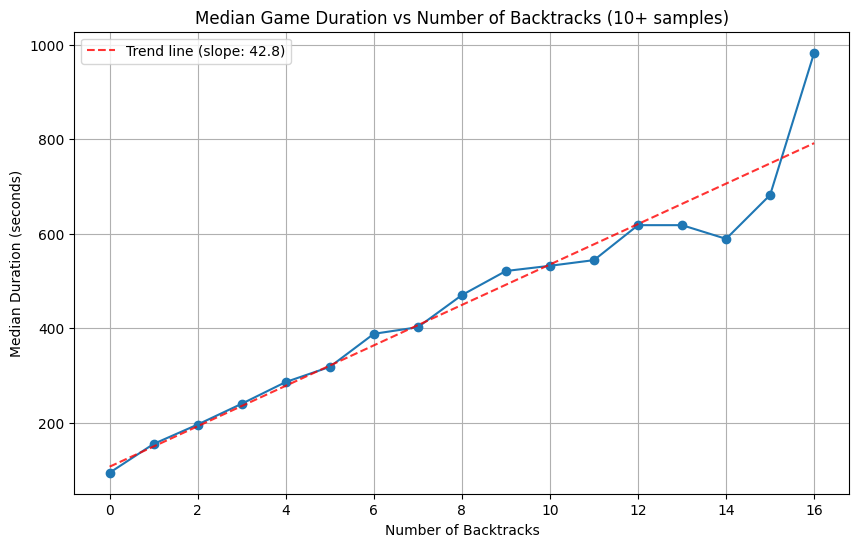

Counts of games with each number of backtracks:
backtracks
0     42323
1      5095
2      1726
3       815
4       411
5       268
6       173
7       138
8        89
9        71
10       39
11       29
12       24
13       26
14       10
15       13
16       11
dtype: int64


In [54]:
import numpy as np

# Group finished games by number of backtracks and calculate median duration
backtrack_counts = finished_games.groupby(finished_games['backtracks'].apply(len)).size()
backtrack_durations = finished_games.groupby(finished_games['backtracks'].apply(len))['durationInSec'].median()

# Filter to keep only counts with at least 10 samples
filtered_counts = backtrack_counts[backtrack_counts >= 10]
filtered_durations = backtrack_durations[filtered_counts.index]

# Create the plot
plt.figure(figsize=(10,6))
plt.plot(filtered_durations.index, filtered_durations.values, marker='o')
plt.xlabel('Number of Backtracks')
plt.ylabel('Median Duration (seconds)')
plt.title('Median Game Duration vs Number of Backtracks (10+ samples)')
plt.grid(True)

# Add a trend line
z = np.polyfit(filtered_durations.index, filtered_durations.values, 1)
p = np.poly1d(z)
plt.plot(filtered_durations.index, p(filtered_durations.index), "r--", alpha=0.8, 
         label=f'Trend line (slope: {z[0]:.1f})')

plt.legend()
plt.show()

print("Counts of games with each number of backtracks:")
print(filtered_counts)



In [55]:
# Was backtracking the right decision

In [56]:
# Category of the backtrack vs category of destination
# Category of the backtrack vs category of new page e.g. ....a;<;b... compare category of a and b

In [57]:
categories = pd.read_csv('data/wikispeedia_paths-and-graph/categories.tsv', sep='\t',comment='#', names=['page', 'category'])
categories['page'] = categories['page'].apply(lambda x: urllib.parse.unquote(x).replace('_', ' '))

categories.head()

,page,category
0,Áedán mac Gabráin,subject.History.British_History.British_Histor...
1,Áedán mac Gabráin,subject.People.Historical_figures
2,Åland,subject.Countries
3,Åland,subject.Geography.European_Geography.European_...
4,Édouard Manet,subject.People.Artists


In [58]:
paths_df.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,target,is_finished,type,backtracks,traversed
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,African slave trade,True,NaN,[],"[14th century, 15th century, 16th century, Pac..."
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,African slave trade,True,NaN,[],"[14th century, Europe, Africa, Atlantic slave ..."
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,African slave trade,True,NaN,[],"[14th century, Niger, Nigeria, British Empire,..."
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,Greece,True,NaN,[],"[14th century, Renaissance, Ancient Greece, Gr..."
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,John F. Kennedy,True,NaN,[],"[14th century, Italy, Roman Catholic Church, H..."


In [59]:


# Get all backtrack targets
backtrack_targets = paths_df[paths_df['backtracks'].apply(len) > 0][['backtracks','target']]
print(backtrack_targets.head())
# Create a list to store individual backtrack entries
backtrack_entries = []

# Iterate through each row that has backtracks
for _, row in backtrack_targets.iterrows():
    # For each backtrack in the row
    for backtrack in row['backtracks']:
        # Add an entry with the backtrack and target
        backtrack_entries.append({
            'backtrack': backtrack,
            'target': row['target']
        })

# Convert to DataFrame
backtrack_df = pd.DataFrame(backtrack_entries)

print("\nArticle of backtrack vs target")
print(backtrack_df.value_counts().head(20))


                                           backtracks   target
10                                         [Sunlight]  Rainbow
13     [Sunlight, Rain, Earth's atmosphere, Sunlight]  Rainbow
14                                      [Cloud, Rain]  Rainbow
16  [Republic of Ireland, Europe, Europe, Republic...  Rainbow
19         [Physics, Ultraviolet, Earth's atmosphere]  Rainbow

Article of backtrack vs target
backtrack         target     
Soybean           Bean           111
Herbivore         Zebra           89
Protein           Bean            62
Cell (biology)    Telephone       46
Sport             Tiger_Woods     42
Salsa music       Bean            42
Coffee            Bean            38
Optical fiber     Telephone       37
Animal            Zebra           34
Mexico            Bean            34
Sound             Telephone       31
Plant             Bean            30
Eye               Telephone       30
Internet          Telephone       30
Computer science  Telephone       28
Food 

In [60]:
#target with most backtracks
backtrack_df['target'].value_counts().head(20)


target
Bean                      805
Telephone                 722
Zebra                     690
Viking                    595
Tiger_Woods               268
Fugu                      199
Vole                      151
Nurse_sharks              145
Three_Laws_of_Robotics    124
Apple                     123
Google                    121
Wood                      111
Monkey                     87
IPod                       82
Soil_moisture              81
Dog                        79
Banana                     77
Indian_Peafowl             77
Juice                      76
ITunes                     74
Name: count, dtype: int64

In [65]:
#targets with the highest average backtracks
paths_df['backtrack_length'] = paths_df['backtracks'].apply(len)
# Get target counts
target_counts = paths_df['target'].value_counts()
# Filter for targets with >10 paths and calculate mean backtrack length
paths_df[paths_df['target'].isin(target_counts[target_counts > 10].index)]\
    .groupby('target')['backtrack_length'].median()\
    .sort_values(ascending=False)\
    .head(20)



target
Leaning Tower of Pisa        3.0
British Virgin Islands       2.0
Rhythm and blues             1.0
Enzyme kinetics              1.0
Brown trout                  1.0
Onion                        1.0
Community                    1.0
Alfred Nobel                 1.0
Metallurgy                   1.0
Einsteinium                  1.0
Statue of Zeus at Olympia    1.0
Walt_Disney                  1.0
Set                          1.0
Turmeric                     1.0
Recycling                    1.0
Sickle-cell disease          1.0
Dik-dik                      1.0
Snow Goose                   1.0
Day                          1.0
Menthol                      1.0
Name: backtrack_length, dtype: float64

In [66]:
paths_df[paths_df['target'].isin(target_counts[target_counts > 30].index)]\
    .groupby('target')['backtrack_length'].mean()\
    .sort_values(ascending=True)\
    .head(20)

target
Flower                    0.000000
George Washington         0.000000
Iraq                      0.022222
Electron                  0.024390
Republic of China         0.025641
Earth                     0.026316
Mexico                    0.026316
Abraham Lincoln           0.028571
Roman Empire              0.030303
United States Congress    0.032258
Indonesia                 0.032258
Christianity              0.035088
London                    0.037736
England                   0.040000
Hurricane Katrina         0.047619
Oregon                    0.050000
Baghdad                   0.054054
Aristotle                 0.055556
Ancient Greece            0.055556
Great Lakes               0.060000
Name: backtrack_length, dtype: float64

In [ ]:
# longueur de la page? nombre de lien sortant? 
# was backtrack a good idea? Distance de la target avant/apres backtracks